# Prediction of the number of COVID-19 cases in the US using least squares

This is a case study to predict the number of COVID-19 positive cases in the US, using the data from CDC (https://covidtracking.com/api/us/daily.csv obtained 3/22/2020, which includes data from 3/4-3/22). This is our "training data". Our goal is to predict the number of positive cases at the end of March, 2020, which is the time when this notebook is introduced to you in the class. You will be able to see the difference between the real data (i.e. the "test data") and the prediction made today (i.e. the "generalization error"). 

The code was originally written by Prof. Yang Feng (New York University) in R. I only adapted it to the Python version.

Lin Lin

3/22/2020 (when the notebook is created)

3/29/2020 (added real data from CDC)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.stats import t

date = []
cases = []
with open('daily_03222020.csv', newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        date.append(row["date"][6:])
        cases.append(float(row["positive"]))
        line_count += 1
    print(f'The total number of days is {line_count}. ')


The total number of days is 19. 


Linear plot, we observe that the number of cases grow very rapidly, but do not really know how to use the data to make prediction.

Text(0.5, 1.0, 'Linear plot')

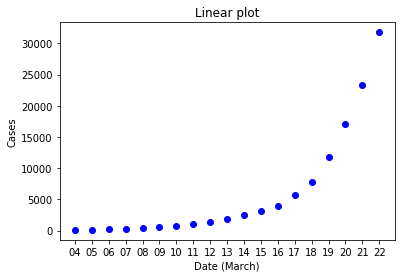

In [2]:
plt.plot(date,cases,"bo")
plt.xlabel('Date (March)')
plt.ylabel('Cases')
plt.yscale('linear')
plt.title('Linear plot')

If we plot the y-axis in a log scale, this is nearly a straight line! (i.e. the growth is indeed exponential) 

Text(0.5, 1.0, 'Log plot (base 10)')

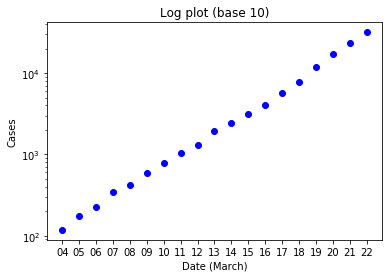

In [3]:
plt.plot(date,cases,"bo")
plt.xlabel('Date (March)')
plt.ylabel('Cases')
plt.yscale('log')
plt.title('Log plot (base 10)')

Can we fit the data and make predictions?

The following systems of linear equations cannot hold for every training data.
$$
y_i = a x_i + b, \quad i=1,\ldots, n_{\text{train}},
$$

Change the goal: find the solution $(a,b)$ in the least-squares sense:
$$
\min_{a,b} \sum_{i=1}^{n_{\text{train}}}(a x_i+b-y_i)^2.
$$

a= 0.1314416735097753 , b= 1.5655708822721086


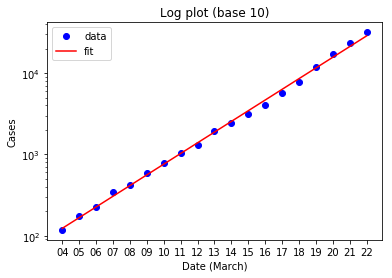

In [4]:
x = np.array(date).astype(np.float)
y_train = np.log10(cases)
n_train = len(x)

A=np.array([x, np.ones(n_train)]).T

# Solve the least squares problem
ATA = np.dot(A.T, A)
ATy = np.dot(A.T, y_train)
(a,b) = np.linalg.solve(ATA, ATy)
print("a=",a,", b=", b)

# Check how the fitting works

y_fit = a*x+b
cases_fit = 10**y_fit
plt.plot(date,cases,"bo",label='data')
plt.plot(date,cases_fit,"r-",label='fit')

plt.xlabel('Date (March)')
plt.ylabel('Cases')
plt.yscale('log')
plt.title('Log plot (base 10)')
plt.legend()


Now we have a **model**, and we can use it to do some **prediction**.

In [5]:
date_pred = np.arange(23,31)
y_pred = a * date_pred + b
cases_pred = 10**y_pred
for i in range(len(date_pred)):
    print("March ", date_pred[i], ", Number of predicted cases = ", np.int(cases_pred[i]))

March  23 , Number of predicted cases =  38790
March  24 , Number of predicted cases =  52501
March  25 , Number of predicted cases =  71057
March  26 , Number of predicted cases =  96173
March  27 , Number of predicted cases =  130165
March  28 , Number of predicted cases =  176172
March  29 , Number of predicted cases =  238440
March  30 , Number of predicted cases =  322716


OK, the model shows that on March 30, there will be > 300,000 confirmed cases in the US. Is this model trustworthy?

(The following discussion is optional for the Math 54 class)

First, we compute the coefficient of determination, or the $R^2$ (pronounced as "R-squared") value of the fitting. (see https://en.wikipedia.org/wiki/Coefficient_of_determination). If $R^2$ is very close to $1$, then the model fits the data very accurately.

In [6]:
y_train_mean = np.mean(y_train)
SS_tot = np.sum((y_train - y_train_mean)**2) # total variation
SS_reg = np.sum((y_fit - y_train_mean)**2) # explained variation

R2 = SS_reg / SS_tot

print("R2 = ", R2)


R2 =  0.9980808822994567


Let us now compute the so-called 95% confidence interval for the number of predicted cases.

Formula can be obtained from e.g. http://statweb.stanford.edu/~susan/courses/s141/horegconf.pdf

In [7]:
sigma2 = np.sum((y_fit-y_train)**2) / (n_train-2) # minus 2 because a linear model has two degrees of freedom
t_val = t.ppf(1-0.05/2, n_train-2) # critical value of the t-distribution with 95% of the confidence interval

x_train_mean = np.mean(x)
SS_x_tot = np.sum((x - x_train_mean)**2)

sigma_y_pred = np.zeros(len(date_pred))

for i in range(len(date_pred)):
    sigma_y_pred[i] = np.sqrt(sigma2) * np.sqrt(1.0/n_train + (date_pred[i] - x_train_mean)**2/SS_x_tot) 

y_pred_low  = y_pred - t_val * sigma_y_pred
y_pred_high = y_pred + t_val * sigma_y_pred

cases_pred_low = 10**y_pred_low
cases_pred_high = 10**y_pred_high


for i in range(len(date_pred)):
    print("March ", date_pred[i], ", Number of predicted cases = ", np.int(cases_pred[i]), 
          ", low = ", np.int(cases_pred_low[i]), ", high = ", np.int(cases_pred_high[i]))

March  23 , Number of predicted cases =  38790 , low =  35900 , high =  41913
March  24 , Number of predicted cases =  52501 , low =  48298 , high =  57070
March  25 , Number of predicted cases =  71057 , low =  64969 , high =  77717
March  26 , Number of predicted cases =  96173 , low =  87387 , high =  105842
March  27 , Number of predicted cases =  130165 , low =  117532 , high =  144156
March  28 , Number of predicted cases =  176172 , low =  158066 , high =  196351
March  29 , Number of predicted cases =  238440 , low =  212570 , high =  267458
March  30 , Number of predicted cases =  322716 , low =  285854 , high =  364332


**3/29**:

Now that we have the real data from CDC, let us compare with the prediction.

The total number of days is 26. 


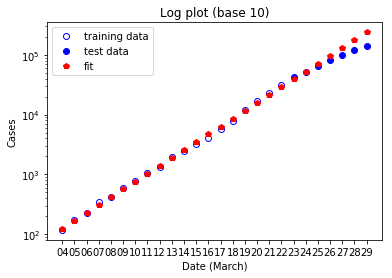

In [22]:
date = []
cases = []
with open('daily_03292020.csv', newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        date.append(row["date"][6:])
        cases.append(float(row["positive"]))
        line_count += 1
    print(f'The total number of days is {line_count}. ')

    
x = np.array(date).astype(np.float)
y_fit = a*x+b
cases_fit = 10**y_fit
plt.plot(date[0:19],cases[0:19],"bo",label='training data',fillstyle='none')
plt.plot(date[19:],cases[19:],"bo",label='test data')
plt.plot(date,cases_fit,"rp",label='fit')

plt.xlabel('Date (March)')
plt.ylabel('Cases')
plt.yscale('log')
plt.title('Log plot (base 10)')
plt.legend()


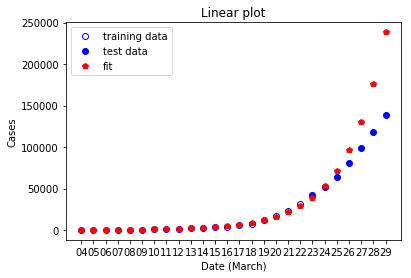

In [23]:
plt.plot(date[0:19],cases[0:19],"bo",label='training data',fillstyle='none')
plt.plot(date[19:],cases[19:],"bo",label='test data')
plt.plot(date,cases_fit,"rp",label='fit')

plt.xlabel('Date (March)')
plt.ylabel('Cases')
plt.title('Linear plot')
plt.legend()
